# 🕵️‍♂️ Modül 1: Olist 360° - Teşhis ve Veri Temeli (Diagnosis)

**Proje Vizyonu:** Olist 360° Intelligence Suite, e-ticaret operasyonlarını veriye dayalı kararlarla optimize eden uçtan uca bir yapay zeka çözümüdür.

**Bu Modülün Amacı (Diagnosis):**
Bir doktorun hastasını muayene etmesi gibi, önce şirketin verisini "muayene" edeceğiz.
1.  **Veri Bütünlüğü:** Elimizdeki veri ne kadar temiz?
2.  **Operasyonel Röntgen:** Siparişler zamanında gidiyor mu?
3.  **Müşteri Röntgeni:** Müşterilerimiz kim? Tekrar geliyorlar mı?

**Çıktı:** Temizlenmiş ve birleştirilmiş `Master Data` ve stratejik ilk bulgular.


In [1]:

# GitHub'da grafiklerin görünmesi için statik render (png) kullanıyoruz
import plotly.io as pio
pio.renderers.default = "png"

import sys
import os

# Docker içinden değil, lokalden bağlandığımız için host'u 'localhost' yapıyoruz
os.environ["POSTGRES_HOST"] = "localhost"

import pandas as pd
import polars as pl
import plotly.express as px
from sqlalchemy import create_engine, text

# Proje kök dizinine erişim (src modülünü bulmak için)
sys.path.append(os.path.abspath('..'))

from src.config import DATABASE_URL

print("✅ Kütüphaneler yüklendi ve konfigürasyon alındı.")

✅ Kütüphaneler yüklendi ve konfigürasyon alındı.


In [2]:
# Veritabanı Bağlantısı
engine = create_engine(DATABASE_URL)

def get_table_info():
    query = """
    SELECT table_name, 
           (SELECT COUNT(*) FROM information_schema.columns WHERE table_name=t.table_name) as columns
    FROM information_schema.tables t 
    WHERE table_schema = 'public';
    """
    with engine.connect() as conn:
        df = pd.read_sql(query, conn)
    return df

print("Veritabanındaki Tablolar:")
get_table_info()

Veritabanındaki Tablolar:


,table_name,columns
0,sellers,4
1,order_reviews,7
2,product_category_name_translation,2
3,products,9
4,customer_segments,6
5,orders,8
6,order_items,7
7,customers,5
8,geolocation,5
9,order_payments,5


## 🚀 Adım 1: Verileri Okuma ve Birleştirme (Data Mart)

Analiz yapabilmek için parçalı tabloları (Orders, Items, Products, Customers) tek bir **Master Tablo** haline getirmeliyiz.
Bunun için `Polars` kütüphanesini kullanacağız (Pandas'tan çok daha hızlıdır).

In [3]:
# Tabloları Polars ile okuyoruz
print("⏳ Tablolar okunuyor...")

df_orders = pl.read_database("SELECT * FROM orders", connection=engine)
df_items = pl.read_database("SELECT * FROM order_items", connection=engine)
df_products = pl.read_database("SELECT * FROM products", connection=engine)
df_customers = pl.read_database("SELECT * FROM customers", connection=engine)

print(f"✅ Veriler yüklendi:\n- Orders: {df_orders.height} satır\n- Items: {df_items.height} satır\n- Products: {df_products.height} satır\n- Customers: {df_customers.height} satır")

⏳ Tablolar okunuyor...
✅ Veriler yüklendi:
- Orders: 99441 satır
- Items: 112650 satır
- Products: 32951 satır
- Customers: 99441 satır


In [4]:
# Veri Birleştirme (Join İşlemleri)
# Mantık: Order Items (En detaylı tablo) -> Orders -> Products -> Customers

master_df = (
    df_items.join(df_orders, on="order_id", how="left")
    .join(df_products, on="product_id", how="left")
    .join(df_customers, on="customer_id", how="left")
)

print(f"🧩 Master Tablo Oluşturuldu: {master_df.height} satır, {master_df.width} sütun")
master_df.head()

🧩 Master Tablo Oluşturuldu: 112650 satır, 26 sütun


order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
str,i64,str,str,str,f64,f64,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,str,i64,str,str
"""00010242fe8c5a6d1ba2dd792cb162…",1,"""4244733e06e7ecb4970a6e2683c13e…","""48436dade18ac8b2bce089ec2a0412…","""2017-09-19 09:45:35""",58.9,13.29,"""3ce436f183e68e07877b285a838db1…","""delivered""","""2017-09-13 08:59:02""","""2017-09-13 09:45:35""","""2017-09-19 18:34:16""","""2017-09-20 23:43:48""","""2017-09-29 00:00:00""","""cool_stuff""",58,598,4,650,28,9,14,"""871766c5855e863f6eccc05f988b23…",28013,"""campos dos goytacazes""","""RJ"""
"""00018f77f2f0320c557190d7a144bd…",1,"""e5f2d52b802189ee658865ca93d83a…","""dd7ddc04e1b6c2c614352b383efe2d…","""2017-05-03 11:05:13""",239.9,19.93,"""f6dd3ec061db4e3987629fe6b26e5c…","""delivered""","""2017-04-26 10:53:06""","""2017-04-26 11:05:13""","""2017-05-04 14:35:00""","""2017-05-12 16:04:24""","""2017-05-15 00:00:00""","""pet_shop""",56,239,2,30000,50,30,40,"""eb28e67c4c0b83846050ddfb8a35d0…",15775,"""santa fe do sul""","""SP"""
"""000229ec398224ef6ca0657da4fc70…",1,"""c777355d18b72b67abbeef9df44fd0…","""5b51032eddd242adc84c38acab88f2…","""2018-01-18 14:48:30""",199.0,17.87,"""6489ae5e4333f3693df5ad4372dab6…","""delivered""","""2018-01-14 14:33:31""","""2018-01-14 14:48:30""","""2018-01-16 12:36:48""","""2018-01-22 13:19:16""","""2018-02-05 00:00:00""","""moveis_decoracao""",59,695,2,3050,33,13,33,"""3818d81c6709e39d06b2738a8d3a24…",35661,"""para de minas""","""MG"""
"""00024acbcdf0a6daa1e931b038114c…",1,"""7634da152a4610f1595efa32f14722…","""9d7a1d34a5052409006425275ba1c2…","""2018-08-15 10:10:18""",12.99,12.79,"""d4eb9395c8c0431ee92fce09860c5a…","""delivered""","""2018-08-08 10:00:35""","""2018-08-08 10:10:18""","""2018-08-10 13:28:00""","""2018-08-14 13:32:39""","""2018-08-20 00:00:00""","""perfumaria""",42,480,1,200,16,10,15,"""af861d436cfc08b2c2ddefd0ba0746…",12952,"""atibaia""","""SP"""
"""00042b26cf59d7ce69dfabb4e55b4f…",1,"""ac6c3623068f30de03045865e4e100…","""df560393f3a51e74553ab94004ba5c…","""2017-02-13 13:57:51""",199.9,18.14,"""58dbd0b2d70206bf40e62cd34e84d7…","""delivered""","""2017-02-04 13:57:51""","""2017-02-04 14:10:13""","""2017-02-16 09:46:09""","""2017-03-01 16:42:31""","""2017-03-17 00:00:00""","""ferramentas_jardim""",59,409,1,3750,35,40,30,"""64b576fb70d441e8f1b2d7d446e483…",13226,"""varzea paulista""","""SP"""


## 🔍 Adım 2: EDA ve Görselleştirme

Veriyi birleştirdik. Şimdi **Plotly** kullanarak veriyi tanıyalım.
Cevap aradığımız sorular:
1.  Veride eksiklikler var mı?
2.  Siparişlerin durumu ne? (Teslim edildi, iptal vb.)
3.  Zaman içinde satışlar nasıl değişmiş?
4.  En çok hangi kategoride ürün satıyoruz?

In [5]:
# 1. Eksik Veri Analizi ve Stratejisi
null_counts = master_df.null_count()
print("Eksik Veri Sayıları:")
for col in null_counts.columns:
    count = null_counts[col][0]
    if count > 0:
        print(f"❌ {col}: {count} eksik")


Eksik Veri Sayıları:
❌ order_approved_at: 15 eksik
❌ order_delivered_carrier_date: 1194 eksik
❌ order_delivered_customer_date: 2454 eksik
❌ product_category_name: 1603 eksik
❌ product_name_lenght: 1603 eksik
❌ product_description_lenght: 1603 eksik
❌ product_photos_qty: 1603 eksik
❌ product_weight_g: 18 eksik
❌ product_length_cm: 18 eksik
❌ product_height_cm: 18 eksik
❌ product_width_cm: 18 eksik


### 🛠️ Eksik Veri Stratejisi (Karar Anı)

1.  **Teslimat Tarihleri (2454 eksik):** Bunlar henüz teslim edilmemiş veya iptal edilmiş siparişler. **Lojistik Modülü** için sadece teslim edilmiş (`delivered`) siparişleri kullanacağız, bu yüzden bu eksikler sorun değil (filtrelenecek).
2.  **Ürün Bilgileri (1603 eksik):** Kategori veya boyut bilgisi olmayan ürünler. Bunları **Growth Modülü** için "Unknown" olarak dolduracağız veya analizden çıkaracağız.
3.  **Boyutlar (18 eksik):** Çok az olduğu için bu satırları eğitim setinden çıkarabiliriz.

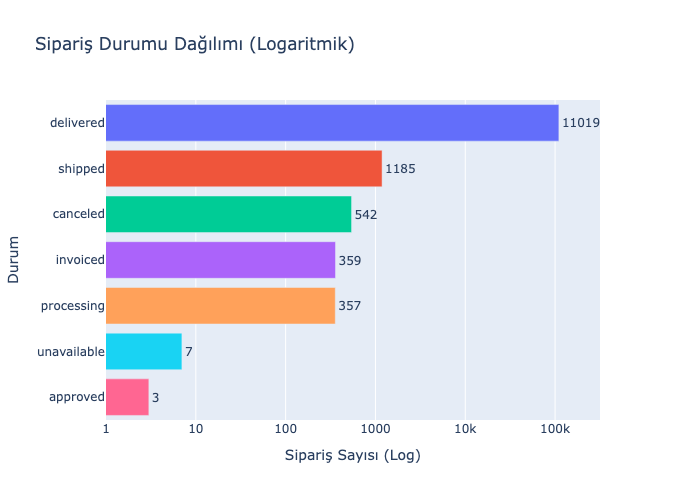

In [6]:
# 2. Sipariş Durumu (Bar Chart - Final Düzeltme)
status_counts = (
    master_df.group_by("order_status")
    .len()
    .sort("len", descending=True)
    .to_pandas()
)

fig = px.bar(status_counts, x='len', y='order_status', 
             orientation='h', 
             title='Sipariş Durumu Dağılımı (Logaritmik)',
             text='len',
             color='order_status')

# Logaritmik eksen ayarları
# range=[0, 5.5] -> 10^5.5 ≈ 316,000 (Yazıların sığması için yeterli alan)
# dtick=1 -> Sadece 10'un ana kuvvetlerini göster (10, 100, 1k...)
fig.update_xaxes(type="log", title="Sipariş Sayısı (Log)", range=[0, 5.5], dtick=1)
fig.update_yaxes(title="Durum")

fig.update_layout(showlegend=False, margin=dict(r=100))
fig.update_traces(textposition='outside')
fig.show()

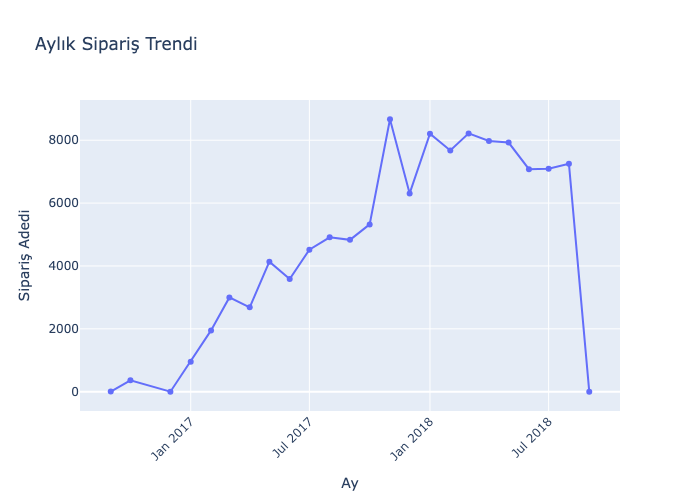

In [7]:
# 3. Aylık Satış Trendi
monthly_sales = (
    master_df.with_columns(pl.col("order_purchase_timestamp").str.to_datetime())
    .sort("order_purchase_timestamp")
    .group_by_dynamic("order_purchase_timestamp", every="1mo")
    .agg(pl.len().alias("order_count"))
    .with_columns(pl.col("order_purchase_timestamp").dt.strftime("%Y-%m").alias("month_year"))
    .to_pandas()
)

fig = px.line(monthly_sales, x='month_year', y='order_count', 
              title='Aylık Sipariş Trendi',
              markers=True)

fig.update_xaxes(title='Ay', tickangle=-45)
fig.update_yaxes(title='Sipariş Adedi')
fig.show()

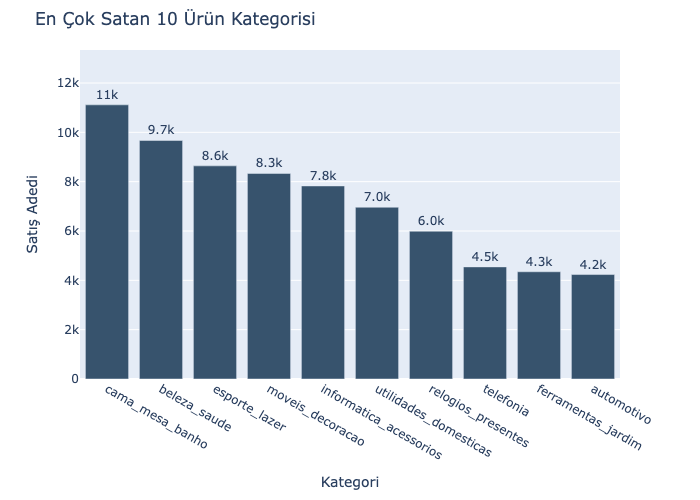

In [8]:
# 4. En Çok Satan Kategoriler
top_categories = (
    master_df.group_by("product_category_name")
    .len()
    .sort("len", descending=True)
    .head(10)
    .to_pandas()
)

max_val = top_categories['len'].max()

fig = px.bar(top_categories, x='product_category_name', y='len',
             title='En Çok Satan 10 Ürün Kategorisi',
             text_auto='.2s')

fig.update_traces(marker_color='rgb(55, 83, 109)', textposition='outside')
fig.update_layout(xaxis_title="Kategori", 
                  yaxis_title="Satış Adedi", 
                  yaxis_range=[0, max_val * 1.2], 
                  margin=dict(t=50, b=100))
fig.show()

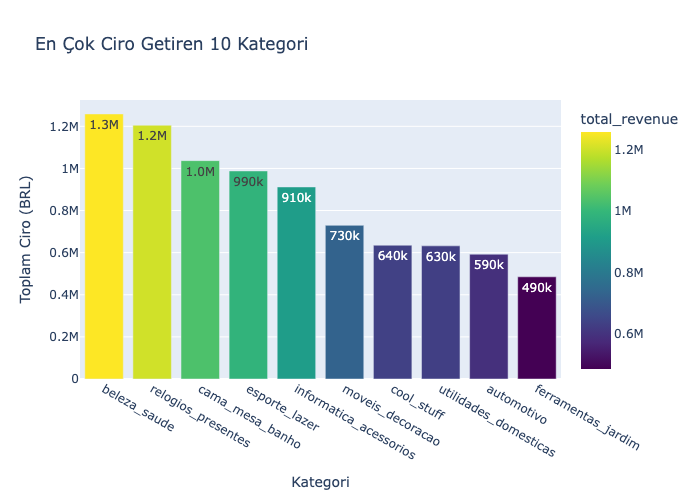

In [9]:
# 4.1 En Çok Ciro Getiren Kategoriler (Revenue)
# Satış adedi kadar, getirdiği ciro da önemlidir.

top_revenue = (
    master_df.group_by("product_category_name")
    .agg(pl.col("price").sum().alias("total_revenue"))
    .sort("total_revenue", descending=True)
    .head(10)
    .to_pandas()
)

fig = px.bar(top_revenue, x='product_category_name', y='total_revenue',
             title='En Çok Ciro Getiren 10 Kategori',
             text_auto='.2s', color='total_revenue', color_continuous_scale='Viridis')

fig.update_layout(xaxis_title="Kategori", yaxis_title="Toplam Ciro (BRL)")
fig.show()

## 🕵️‍♂️ Adım 3: Derinlemesine Analiz (Deep Dive)

Veriyi tanıdık, şimdi işin derinine inelim. Müşteri davranışlarını anlamak için şu sorulara cevap arayacağız:
1.  **Zamanlama:** Müşteriler en çok hangi gün ve saatte alışveriş yapıyor?
2.  **Ödeme:** Taksitli alışveriş yaygın mı? Hangi ödeme yöntemleri tercih ediliyor?
3.  **Memnuniyet:** Teslimat süresi ile Müşteri Puanı (Review Score) arasında nasıl bir ilişki var?

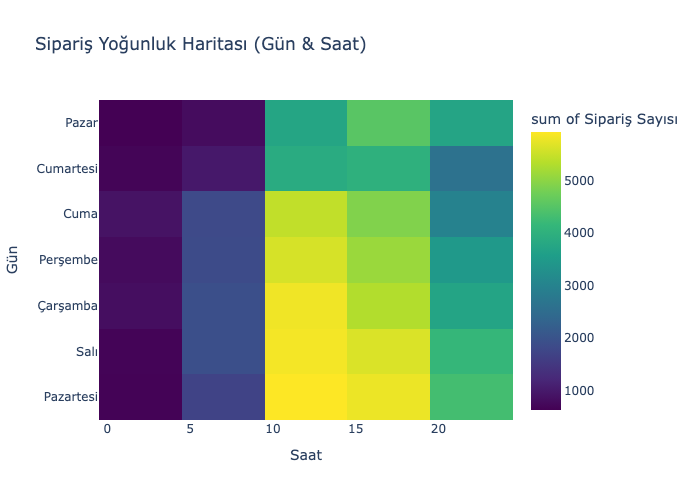

In [10]:
# 3.1 Zaman Analizi (Heatmap)
# Siparişlerin gün ve saat dağılımı

master_df = master_df.with_columns([
    pl.col("order_purchase_timestamp").str.to_datetime().dt.weekday().alias("weekday"),
    pl.col("order_purchase_timestamp").str.to_datetime().dt.hour().alias("hour")
])

time_heatmap = (
    master_df.group_by(["weekday", "hour"])
    .len()
    .sort(["weekday", "hour"])
    .to_pandas()
)

# Gün isimlerini ekleyelim
days = {1: 'Pazartesi', 2: 'Salı', 3: 'Çarşamba', 4: 'Perşembe', 5: 'Cuma', 6: 'Cumartesi', 7: 'Pazar'}
time_heatmap['day_name'] = time_heatmap['weekday'].map(days)

fig = px.density_heatmap(time_heatmap, x="hour", y="day_name", z="len", 
                         title="Sipariş Yoğunluk Haritası (Gün & Saat)",
                         labels={'hour': 'Saat', 'day_name': 'Gün', 'len': 'Sipariş Sayısı'},
                         color_continuous_scale='Viridis')
fig.update_layout(yaxis={'categoryorder':'array', 'categoryarray': list(days.values())})
fig.show()

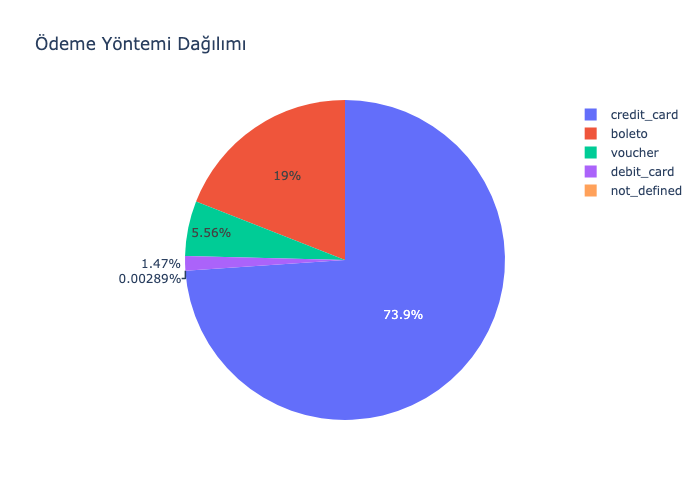

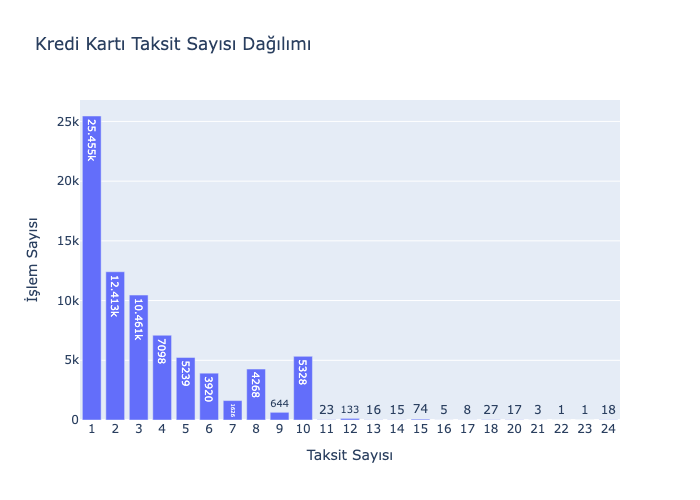

In [11]:
# 3.2 Ödeme Analizi
# Ödeme verisini çekmemiştik, şimdi çekip birleştirelim
df_payments = pl.read_database("SELECT * FROM order_payments", connection=engine)

# Ödeme Tipi Dağılımı
payment_dist = df_payments.group_by("payment_type").len().to_pandas()

fig1 = px.pie(payment_dist, values='len', names='payment_type', title='Ödeme Yöntemi Dağılımı')
fig1.show()

# Taksit Analizi (Sadece Kredi Kartı)
# 1. Taksit sayısı 0 olanları (Hatalı veri) çıkaralım
# 2. String'e çevirelim ki grafik 'Sayısal' sanıp boşluk bırakmasın (1, 2, 3... diye etiket olsun)
installments = (
    df_payments.filter((pl.col("payment_type") == "credit_card") & (pl.col("payment_installments") > 0))
    .with_columns(pl.col("payment_installments").cast(pl.Int64)) # Önce sayı yap (Sıralama için)
    .group_by("payment_installments")
    .len()
    .sort("payment_installments") # Sayısal olarak sırala (1, 2, 10 değil -> 1, 2, 3...)
    .with_columns(pl.col("payment_installments").cast(pl.Utf8)) # Şimdi String yap (Grafik için)
    .to_pandas()
)

fig2 = px.bar(installments, x='payment_installments', y='len', 
              title='Kredi Kartı Taksit Sayısı Dağılımı',
              labels={'payment_installments': 'Taksit Sayısı', 'len': 'İşlem Sayısı'},
              text_auto=True)

# X eksenini kategori olarak zorla (String olduğu için zaten öyle olacak ama garanti olsun)
fig2.update_layout(xaxis_type='category')
fig2.show()

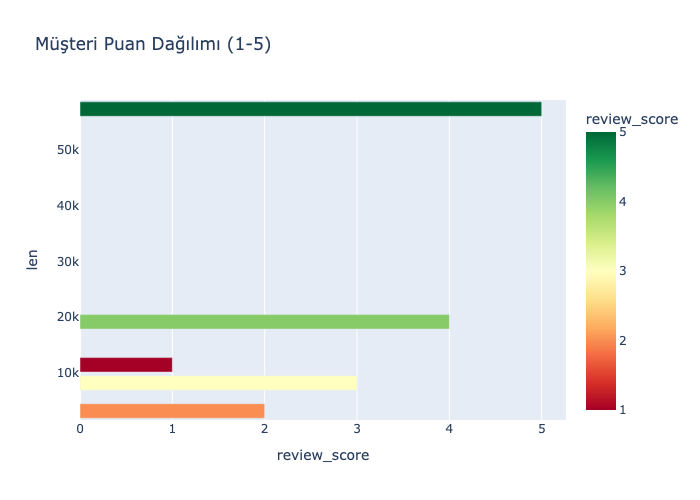

In [12]:
# 3.3 Müşteri Memnuniyeti Analizi
# Review verisini çekelim
df_reviews = pl.read_database("SELECT * FROM order_reviews", connection=engine)

# Puan Dağılımı
score_dist = df_reviews.group_by("review_score").len().sort("review_score").to_pandas()

fig = px.bar(score_dist, x='review_score', y='len', 
             title='Müşteri Puan Dağılımı (1-5)',
             color='review_score', color_continuous_scale='RdYlGn')
fig.show()


## 🏁 Modül 1 Sonucu: Teşhis Konuldu

**Kritik Bulgular:**
1.  **Retention Krizi:** Müşterilerin **%97'si** sadece bir kez alışveriş yapıp gidiyor. (Bkz: Modül 3)
2.  **Lojistik Varyansı:** Eyaletler arası teslimat sürelerinde ciddi tutarsızlıklar var. (Bkz: Modül 2)
3.  **Ödeme Alışkanlığı:** Kredi kartı ve taksit kullanımı yaygın.

**Sıradaki Adım:** Bu bulguları çözüme kavuşturmak için **Modül 2: Lojistik Motoru**'nu devreye alıyoruz.
